In [44]:
import sys
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement
import time
import re
import pandas as pd
import random

from tripadvisor_reviews_scraper import get_reviews_from_url

In [41]:
# pip install -U textblob

Note: you may need to restart the kernel to use updated packages.


In [52]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

from gensim.parsing.preprocessing import strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short

nltk.download('omw-1.4')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from googletrans import Translator
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...


In [ ]:
# if not installed yet, execute
# pip install googletrans==3.1.0a0 
# pip install gensim

In [7]:
# for now we do the cleanings with the data coming from twitter

# url = "https://www.tripadvisor.com/Restaurant_Review-g60763-d12425739-Reviews-Piccola_Cucina_Estiatorio-New_York_City_New_York.html"
# df = get_reviews_from_url(url)

In [93]:
df = pd.read_csv("kw=Piccola Cucina Estiatorio-230120-132053.csv")

In [94]:
df = df[['Content','Restaurant']]

In [95]:
df.head()

,Content,Restaurant
0,Just posted a photo @ Piccola Cucina Estiatorio,Piccola Cucina Estiatorio
1,미국 뉴욕 Piccola Cucina Estiatorio여긴 그닥.. 저 초록색은 ...,Piccola Cucina Estiatorio
2,Piccola Cucina Estiatorio | New York USA | Ma2...,Piccola Cucina Estiatorio
3,We had a team dinnerThank you for a big fun ni...,Piccola Cucina Estiatorio
4,Piccola Cucina Estiatorio ...,Piccola Cucina Estiatorio


In [31]:
df['translated'] = df['Content'].apply(lambda x: translator.translate(x, dest='en').text)

In [159]:
test = df['Content'][6]
test

'ขอตอบแทนนะคะ ถ้าอาหารอิตาลี่แนะนำร้านนี้ค่ะถ้าไม่ชอบ แถวย่านโซโห ตัวเลือกเยอะมากค่ะ ลองเดินดูได้ อ้อ ร้านนี้อยู่ฝั่งตรงข้ามร้าน Laduree ที่ไทยขายแต่มาการอง ที่นี่มีขายอาหารฝรั่งเศษด้วยค่ะ สวนด้านหลังสวยมากPiccola Cucina Estiatorio(646) 781-9183'

In [158]:
def clean_text(text, name):

    text = text.lower()
    text = re.sub(r'http\S+', '', text) # Remove links
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    
    # Remove emoticons
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # text = text.replace(name.lower(), " ") # Remove the name of restaurant
    for n in name.lower().split():
        text = text.replace(n, "")
        
    text = translator.translate(text, dest='en').text # translation to english
    
    text = strip_punctuation(text) # Remove punctuation
    text = strip_non_alphanum(text) # Remove non alphanumeric characters
    text = re.sub(r'\d', '', text) # Remove numbers
    text = re.sub(r'(!)1+', '', text) # remove repetitions
    text = strip_multiple_whitespaces(text) # Remove multiple whitespaces
    
    text = [word for word in text.split() if word not in stopwords and len(word) > 2] # Remove stopwords
    text = [wordnet_lemmatizer.lemmatize(word) for word in text] # lemmatize
    text = " ".join(text)

    return text 

In [160]:
test_out = clean_text(test, 'Piccola Cucina Estiatorio')

In [161]:
test_out

'return Italian food recommended restaurant like Soho area lot option try walking around There also French food vendor The back garden beautiful'

In [162]:
def get_sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

In [165]:
df['cleaned'] = df.apply(lambda row: clean_text(row.Content, row.Restaurant), axis=1)

In [166]:
df = df.replace(r'^s*$', float('NaN'), regex = True) # substitute with empty with NaN
df.dropna(subset = ['cleaned'], inplace = True) # remove empty rows

In [168]:
df['sentiment'] = df.apply(lambda row: get_sentiment(row.cleaned), axis=1)

In [172]:
from collections import Counter
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [173]:
for idx, row in df.iterrows():
    for word in row['cleaned'].split(" "):
        if(row['sentiment'] > 0):
            positive_counts[word]+=1
        elif (row['sentiment'] < 0):
            negative_counts[word]+=1
        else:
            break
        total_counts[word]+=1

In [203]:
positive_counts.most_common()[0:10]

[('new', 15),
 ('york', 11),
 ('soho', 6),
 ('dinner', 4),
 ('beautiful', 4),
 ('delicious', 3),
 ('food', 3),
 ('team', 3),
 ('fun', 3),
 ('newyork', 3)]

In [347]:
negative_counts.most_common()[:10] # it's normal to have 0, they are the best resto

[]

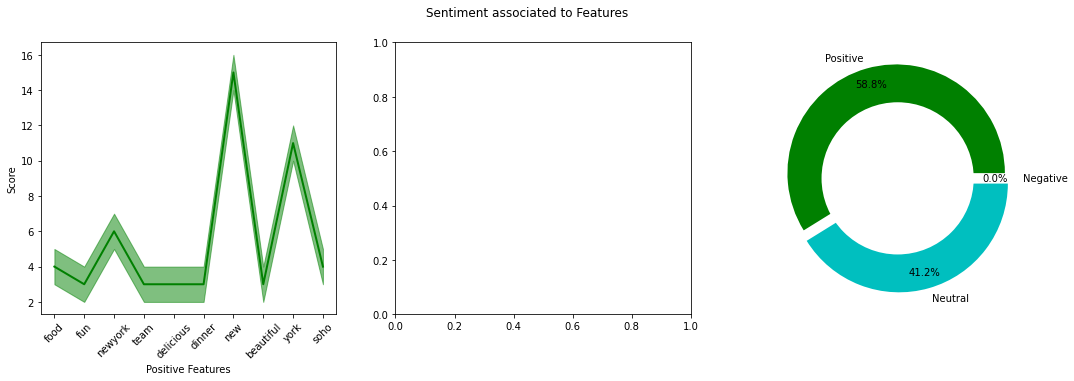

In [352]:
# extract the keys and values from the counter
max_words = 10
pos_words = [x[0] for x in positive_counts.most_common()[:max_words]]
pos_counts = [x[1] for x in positive_counts.most_common()[:max_words]]

neg_words = [x[0] for x in negative_counts.most_common()[:max_words]]
neg_counts = [x[1] for x in negative_counts.most_common()[:max_words]]

max_words_pos = len(pos_words)
max_words_neg = len(neg_words)

random.seed(1)
random.shuffle(pos_words)
random.shuffle(pos_counts)
random.shuffle(neg_words)
random.shuffle(neg_counts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Sentiment associated to Features')

if(max_words_pos):
    ax1.fill_between(pos_words, 
                 [pos_counts[i]+1 for i in range(0,max_words_pos)], 
                 [pos_counts[i]-1 for i in range(0,max_words_pos)], 
                 alpha=.5, 
                 linewidth=1, 
                 color='g')
    ax1.plot(pos_words, pos_counts, linewidth=2, color='g')
    ax1.set_xlabel("Positive Features")
    ax1.set_ylabel('Score')
    ax1.tick_params(axis='x', labelrotation = 45)

if(max_words_neg): # to avoid errors if there are no negative opinions
    ax2.fill_between(neg_words, 
                     [neg_counts[i]+1 for i in range(0,max_words_neg)], 
                     [neg_counts[i]-1 for i in range(0,max_words_neg)], 
                     alpha=.5, 
                     linewidth=1, 
                     color='r')
    ax2.plot(neg_words, neg_counts, linewidth=2, color='r')
    ax2.set_xlabel("Negative Features")
    ax2.set_ylabel('Score')
    ax2.tick_params(axis='x', labelrotation = 45)
    
labels = ['Positive', 'Neutral', 'Negative']
all_counts = [
    df[df['sentiment']>0].sentiment.count(), # pos
    df[df['sentiment']==0].sentiment.count(), # neutral
    df[df['sentiment']<0].sentiment.count() # neg
]
colors = ['g', 'c', 'r']
explode = (0.05, 0.05, 0.05)

ax3.pie(all_counts, colors=colors, labels=labels,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax3 = plt.gcf()
ax3.gca().add_artist(centre_circle)